In [4]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm.notebook import tqdm

import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

import pickle

from sklearn.model_selection import ParameterGrid

In [18]:
from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModelLinear, EachModel
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

from mixturelib.regularizers import RegularizeModel, RegularizeFunc

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
def get_parabola(w, w0=None, y_min=-1, y_max=4):
    y0 = np.linspace(y_min, y_max, 10000)
    x1 = 0.5*(-1*(-w[0]*y0 - w[2])+np.sqrt((-w[0]*y0-w[2])**2-4*(-w[1]*y0**2 - w[3]*y0-w[4])))
    x2 = 0.5*(-1*(-w[0]*y0 - w[2])-np.sqrt((-w[0]*y0-w[2])**2-4*(-w[1]*y0**2 - w[3]*y0-w[4])))

    y_all = np.hstack([y0[::-1], y0])
    x_all = np.hstack([x1[::-1], x2])
    

    return x_all, y_all

In [119]:
def get_data(beta=0.1, l=200):
    np.random.seed(0)

    t = np.linspace(-2, 2, l)

    p = 0.5
    alpha = 0.9
    x0 = 0
    y0 = 0

    x=x1=((t**2)/(2*p))*np.cos(alpha)-t*np.sin(alpha)+x0
    y=y1=((t**2)/(2*p))*np.sin(alpha)+t*np.cos(alpha)+y0
    X = np.vstack([x*y, y**2, x, y, np.ones_like(x)]).T
    Y = x**2
    w1 = np.linalg.inv(X.T@X)@X.T@Y
    x1 += beta*np.random.randn(l)
    y1 += beta*np.random.randn(l)


    p = 0.3
    alpha = 2
    x0 = 5
    y0 = 5
    x=x2=((t**2)/(2*p))*np.cos(alpha)-t*np.sin(alpha)+x0
    y=y2=((t**2)/(2*p))*np.sin(alpha)+t*np.cos(alpha)+y0
    X = np.vstack([x*y, y**2, x, y, np.ones_like(x)]).T
    Y = x**2
    w2 = np.linalg.inv(X.T@X)@X.T@Y
    x2 += beta*np.random.randn(l)
    y2 += beta*np.random.randn(l)


    x = np.hstack([x1, x2])
    y = np.hstack([y1, y2])
    
    return x, y, w1, w2

In [120]:
betas = np.linspace(0.0, 0.5, 20)
betas[0] = 0.001
gammas = np.linspace(0.0, 1.0, 20)
gammas[0] = 0.0001
grid = ParameterGrid({'beta': betas, 
                      'gamma': gammas})

In [176]:
def R(W):
    V = W
    V = V.transpose(0, 1)
    mu = 10000000000.0
    return -mu * ((V[0]**2 - 4*V[1])**2)[0]

In [177]:
item = {'gamma': 0.1, 'beta': 0.4}

x, y, w1, w2 = get_data(beta=item['beta'])

X = np.vstack([x*y, y**2, x, y, np.ones_like(x)]).T
Y = x**2

X_tr = torch.FloatTensor(X).to(device)
Y_tr = torch.FloatTensor(Y).view([-1,1]).to(device)

LIST_A = [torch.FloatTensor([item['gamma']]*n).to(device) for _ in range(K)]
LIST_w = [torch.FloatTensor(w1).view(-1,1).to(device),  
          torch.FloatTensor(w2).view(-1,1).to(device)]

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, 
                               device = device, 
                               A = LIST_A[k], 
                               w = LIST_w[k],
                               OptimizedHyper={}))


HypPar = {'beta': item['beta']}

Rg = RegularizeFunc(ListOfModels = LoM, R=R, device=device, epoch=100)

HpMd = HyperExpertNN(input_dim=5, output_dim = K, device = device)

model = MixtureEM(HyperParameters = HypPar,
                  HyperModel = HpMd, 
                  ListOfModels = LoM,
                  ListOfRegularizeModel=[Rg],
                  device = device, model_type='sample')



In [178]:
model.fit(X_tr, Y_tr, 10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


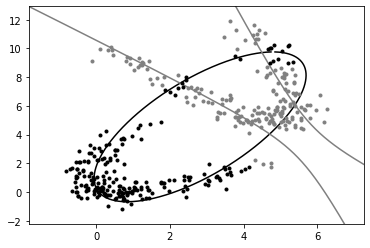

In [179]:
colors = ['black', 'grey', 'red', 'yellow', 'blue']

w1_pred = LoM[0].W.view(-1).cpu().numpy()
w2_pred = LoM[1].W.view(-1).cpu().numpy()
w_pred = [w1_pred, w2_pred]

idx = np.argmax(model.predict(X_tr)[1], axis = 1)

plt.xlim((np.min(x)-1, np.max(x)+1))
plt.ylim((np.min(y)-1, np.max(y)+1))

for k in range(K):
    _ = plt.plot(
        *get_parabola(w_pred[k], y_min=np.min(y)-10, 
                      y_max=np.max(y)+10), color = colors[k])


for i in range(len(model.ListOfModels)):
    _ = plt.plot(
        x[idx == i], y[idx == i], '.', color = colors[i], 
        label = 'model '+str(i+1))



In [175]:
K = 2
n = 5
epochs = 10

experiment_dict = dict()

experiment_dict['betas'] = grid.param_grid[0]['beta']
experiment_dict['gammas'] = grid.param_grid[0]['gamma']

experiment_dict['K'] = K
experiment_dict['n'] = n
experiment_dict['epochs'] = epochs

experiment_dict['results'] = dict()

for item in tqdm(grid):
    key = json.dumps(item)
    experiment_dict['results'][key] = dict()

    x, y, w1, w2 = get_data(beta=item['beta'])
    
    experiment_dict['results'][key]['x'] = x
    experiment_dict['results'][key]['y'] = y
    experiment_dict['results'][key]['w_real'] = [w1, w2]
    
    X = np.vstack([x*y, y**2, x, y, np.ones_like(x)]).T
    Y = x**2

    X_tr = torch.FloatTensor(X).to(device)
    Y_tr = torch.FloatTensor(Y).view([-1,1]).to(device)


    LIST_A = [torch.FloatTensor([item['gamma']]*n).to(device) for _ in range(K)]
    LIST_w = [torch.FloatTensor(w1).view(-1,1).to(device),  
              torch.FloatTensor(w2).view(-1,1).to(device)]


    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, 
                                   device = device, 
                                   A = LIST_A[k], 
                                   w = LIST_w[k],
                                   OptimizedHyper={}))


    HypPar = {'beta': item['beta'], 'alpha': 1e-5}

    Rg = RegularizeFunc(ListOfModels = LoM, R=R, device=device)

    HpMd = HyperExpertNN(input_dim=5, output_dim = K, device = device)

    model = MixtureEM(HyperParameters = HypPar,
                      HyperModel = HpMd, 
                      ListOfModels = LoM,
                      ListOfRegularizeModel=[Rg],
                      device = device, model_type='sample')

    experiment_dict['results'][key]['modbels'] = []
    for _ in range(epochs):
        model.fit(X_tr, Y_tr, 1)
        experiment_dict['results'][key]['models'].append(model)

    w1_pred = LoM[0].W.view(-1).cpu().numpy()
    w2_pred = LoM[1].W.view(-1).cpu().numpy()

    experiment_dict['results'][key]['w_pred'] = [w1_pred, w2_pred]
    experiment_dict['results'][key]['model'] = model

KeyError: 'models'

In [3]:
# with open('./experiment_reg.pkl', 'wb') as f:
#     pickle.dump(experiment_dict, f)
    

NameError: name 'pickle' is not defined